<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/shosim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teorie hromadné obsluhy

## Krátké připomenutí
Kandalova notace

Systémy M/M/1, M/M/n

Pro systém M/M/1 platí rovnice o průměrné délce fronty

$L = \frac{\lambda}{\mu}$

kde L je  průměrná délka fronty

$\lambda$ je intenzita toku požadavků

$\mu$ je intenzita obsluhy

odkaz https://en.wikipedia.org/wiki/Queueing_theory

## Simulace toku požadavků

### Poisonův tok

Poisonův tok je model např. příchodu zákazníků k přepážce, kde jsou obsluhováni. Pro modelování potřebujeme generovat posloupnost příchodů. Interval mezi jednotlivými příchody lze generovat podle následujícího vztahu

$r'=-\frac{1}{\lambda}ln(r)$

kde $r$ je náhodné číslo s rovnoměrným rozložením a $r'$ je náhodný interval mezi dvěma příchody.

Stejným vztahem lze vypočítat náhodnou délku obsluhy (pro systémy M/M/1 nebo M/M/n)

https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/

In [16]:
import numpy as np
from numpy.random import Generator, exponential

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [14]:
from random import random
from math import log as ln

def rndEx(rnd, lam):
  x = rnd()
  result = (-1 / lam) * ln(x) #https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
  return result

### Graf četností

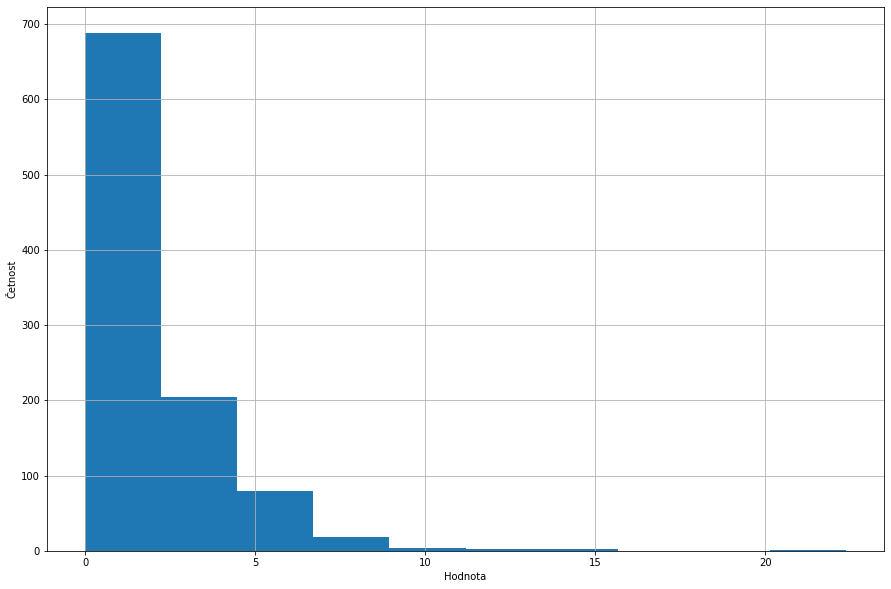

In [22]:
lam = 0.5
data = exponential(1 / lam, 1000)
plt.hist(data)
plt.grid('both')
plt.xlabel('Hodnota')
plt.ylabel('Četnost');

### Časová posloupnost / vznik požadavků

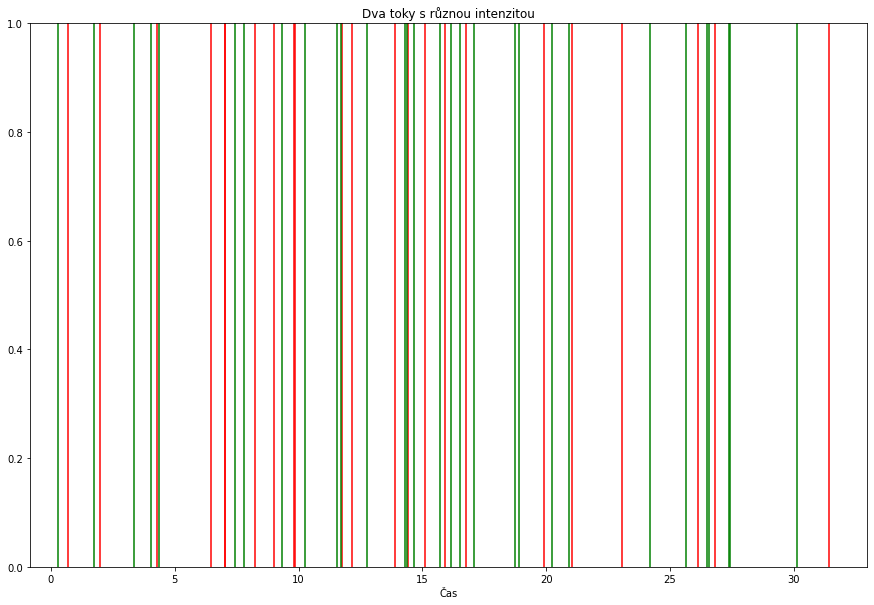

In [8]:
def plotFlow(maxTime, lam, color):
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    plt.axvline(x = currentTime, color =color)

plotFlow(30, 0.5, color='red')    
plotFlow(30, 1, color='green')    
plt.title('Dva toky s různou intenzitou')
plt.xlabel('Čas');

In [9]:
def generateSequence(maxTime, lam):
  result = []
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    result.append(currentTime)
  return result

In [ ]:
sequence = generateSequence(1000)

## Událostní kalendář pro událostní simulaci

Třída pro událostní simulaci. Událostní simulace umožňuje spouštění událostí - akcí v časové souslednosti bez ohledu na souslednost plánování.

In [25]:
class EventCalendar:
  def __init__(self):
    self._queue = []
    pass

  #Metoda pro vykonání jednoho kroku simulace
  def Step(self):
    #z fronty odstraň nejstarší událost
    currentEvent = self._queue.pop(0)

    #vyvolej funkci, která je spojena s danou událostí
    func = currentEvent['executor']
    time = currentEvent['time']
    result = func(time, **currentEvent['kwargs'])
    
    currentEvent['result'] = result
    #vrať událost, která byla zpracována
    return currentEvent

  #Metoda pro získání informace o času nejstarší události, 
  #tj. události, která bude zpracována jako první
  def PrepareNext(self):
    #vrať čas nejstarší události
    return self._queue[0]['time']

  #Vložení události do fronty událostí, 
  #futureTime - čas, kdy bude událost vyvolána
  #f - funkce, která bude v čase události vykonána / volána
  def AddEvent(self, futureTime, f, **kwargs):
    self._queue.append({'time': futureTime, 'executor': f, 'kwargs': kwargs})
    #setřídit frontu / list událostí podle položky time / čas
    self._queue.sort(key = lambda item: item['time'])
    return self

  def __iter__(self):  # we can return self here, because __next__ is implemented
      return self

  def __next__(self):
    return self.Step()


### Použití událostní simulace

In [27]:
calendar = EventCalendar()

def eventPrinter(time, calendar, value):
  print(f'At time\t{time}\tvalue is\t{value}')
  calendar.AddEvent(time + random(), eventPrinter, calendar = calendar, value = value + 1)

calendar.AddEvent(0, eventPrinter, calendar = calendar, value = 0)

for event in calendar:
  print(f"I have served event in time {event['time']}")
  if event['time'] > 5:
    break

At time	0	value is	0
I have served event in time 0
At time	0.6381751298420251	value is	1
I have served event in time 0.6381751298420251
At time	1.3785065909771732	value is	2
I have served event in time 1.3785065909771732
At time	1.5350612898777185	value is	3
I have served event in time 1.5350612898777185
At time	1.9360690855291351	value is	4
I have served event in time 1.9360690855291351
At time	2.4621793053806647	value is	5
I have served event in time 2.4621793053806647
At time	3.4162721119110415	value is	6
I have served event in time 3.4162721119110415
At time	4.357575178757073	value is	7
I have served event in time 4.357575178757073
At time	4.538802922082267	value is	8
I have served event in time 4.538802922082267
At time	5.411593031325945	value is	9
I have served event in time 5.411593031325945


## První simulace SHO

In [ ]:
calendar = Calendar()
λ = 1
µ = 2

### Příchod požadavku

In [ ]:
queue = []
def customerArrived(time, calendar):
  deltaTime = exponential(1 / λ, 1)[0] #jeden čas
  calendar.AddEvent(time + deltaTime, customerArrived, calendar=calendar)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  newCustomer = {'enterTime': time}
  queue.append(newCustomer)
  

### Obsluha požadavku

In [30]:
inService = None

def tryBeginService(time, calendar):
  if inService is None:
    customer = queue.pop()
    inService = customer
    timeOfEnd = exponential(1 / µ, 1)[0] #jeden čas
    calendar.AddEvent(time + timeOfEnd, endService, calendar=calendar)
    inService['beginService'] = time
    inService['endService'] = time + timeOfEnd

def endService(time, calendar):
  finishedCustomer = inService
  inService = None
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  return finishedCustomer

### Sběr statistických ukazatelů

#### Délka fronty

In [ ]:
queueStatistic = {'cumulativeLength': 0, 'value': 0, 'time': 0}
def checkQueueLength(time):
  deltaTime = time - queueStatistic['time']
  queueStatistic['cumulativeLength'] += deltaTime + queueStatistic['value']
  queueStatistic['value'] = len(queue) 

#### Obsluha obsazena

In [ ]:
serviceFull = {'cumulativeLength': 0, 'value': 0, 'time': 0}
def checkServiceFull(time):
  deltaTime = time - serviceFull['time']
  serviceFull['cumulativeLength'] += deltaTime + serviceFull['value']
  serviceFull['value'] = 1
  if inService is None:
    serviceFull['value'] = 0

### Běh simulace

In [29]:
for event in calendar:
  finishedCustomer = event['result']
  if not finishedCustomer is None:
    pass
  if event['time'] > 1000:
    break

array([0.24712413])